In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
import sys
import os

sys.path.append(os.path.abspath('../'))

del sys, os

In [4]:
import pandas as pd
import numpy as np

import torch
from torch import nn

from torch.optim import Adam, SGD

from time import time

In [5]:
import matplotlib.pyplot as plt

In [6]:
# LaTeX rendering in graphs
try:
    plt.rc('text', usetex=True)
except:
    pass

plt.rc('font', family='serif')

# High resolution graphs
%config InlineBackend.figure_format = 'retina'

In [7]:
from models import estimators

In [8]:
from base import samplers

# Samplers

In [9]:
uniform = samplers.distribution2

In [10]:
gaussian = samplers.distribution3

In [11]:
f = torch.tensor(next(uniform()), dtype=torch.float)

In [12]:
g = torch.tensor(np.concatenate((next(gaussian()), next(gaussian())), axis=1))

In [13]:
f.size()

torch.Size([512, 2])

In [14]:
def generate(n=20, batch_size=512):
    
    for _ in range(n):
        
        f = torch.tensor(next(uniform(batch_size))[:, [0]], dtype=torch.float)
        g = torch.tensor(next(gaussian(batch_size)), dtype=torch.float)
        
        yield f, g

# Estimators

## Jensen-Shannon

In [15]:
js = estimators.JensenShannon(input_dimension=1)

In [16]:
optimiser = Adam(js.parameters(), lr=.001)

In [17]:
losses = []
distances = []

for f, g in generate(2000):
    
    js.zero_grad()
    
    loss = js.loss(f, g)
    loss.backward()
    
    optimiser.step()
    
    losses.append(loss.item())
    distances.append(js.distance(f, g).item())
    
losses = np.array(losses)
distances = np.array(distances)

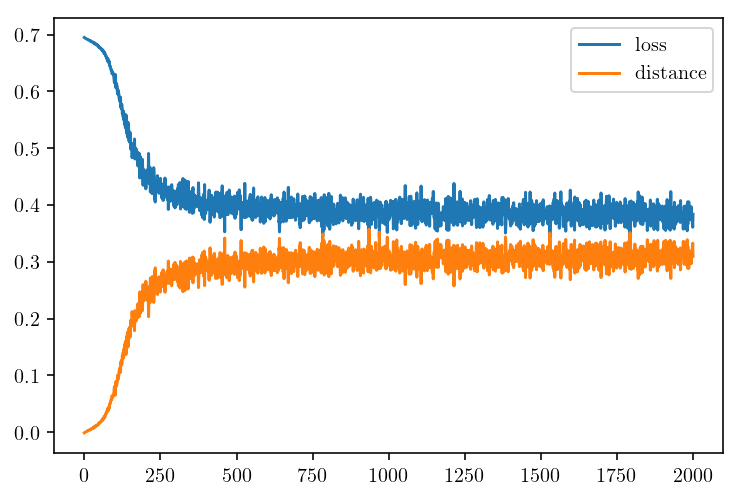

In [18]:
plt.figure()
plt.plot(losses, label='loss')
plt.plot(distances, label='distance')
plt.legend()
plt.show()

## Wasserstein

In [165]:
wasserstein = estimators.Wasserstein(input_dimension=1, hidden_dimension=20, kappa=10)

In [166]:
optimiser = Adam(wasserstein.parameters(), lr=.001)

In [167]:
losses = []
distances = []

for f, g in generate(500):
    
    wasserstein.zero_grad()
    
    loss = wasserstein.loss(f, g, penalised=True)
    loss.backward()
    
    optimiser.step()
    
    losses.append(loss.item())
    distances.append(wasserstein.distance(f, g).item())
    
losses = np.array(losses)
distances = np.array(distances)

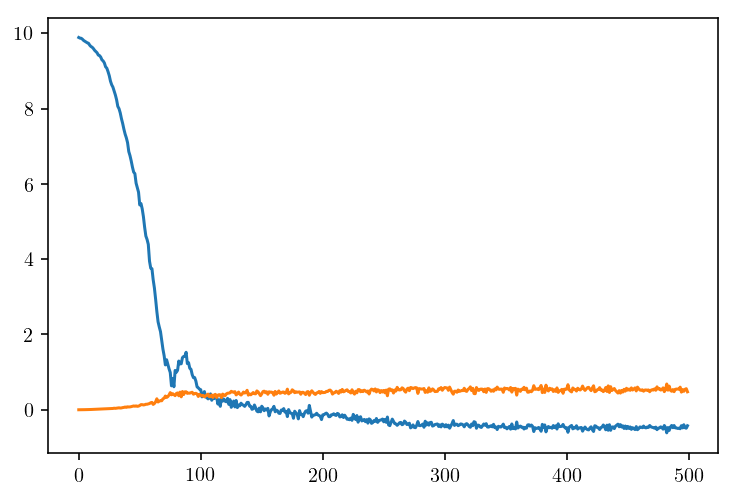

In [168]:
plt.figure()
plt.plot(losses)
plt.plot(distances)
plt.show()